In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST, FashionMNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
from torchvision import datasets, transforms
import medmnist
from medmnist import INFO

/opt/conda/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from fractal_learning.fractals import ifs, diamondsquare
import numpy as np

# データセットを格納するためのリスト
datasets = []

# 50回の実行
for _ in range(15000):
    # フラクタルデータの生成
    system = ifs.sample_system()
    points = ifs.iterate(system, 100000)

    # 画像の生成
    binary_image = ifs.render(points, binary=True)
    gray_image = ifs.render(points, binary=False)
    color_image = ifs.colorize(gray_image)

    background = diamondsquare.colorized_ds()

    composite = background.copy()
    composite[gray_image.nonzero()] = color_image[gray_image.nonzero()]

    # 生成された画像をデータセットに追加
    datasets.append({
        'gray_image': gray_image,
    })

# datasetsをnumpy配列に変換
gray_images = np.array([data['gray_image'] for data in datasets])

# それぞれのデータセットの形状を確認
print("Gray Images Shape:", gray_images.shape)

ModuleNotFoundError: No module named 'fractal_learning'

In [ ]:
from torchvision import transforms
import torch

# あらかじめ定義された変換を取得
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize(size=(28, 28), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.Normalize((0.5, ), (0.5, ))
])

# データセット内の'gray_image'を変換
transformed_gray_images = [transform(gray_image) for gray_image in [data['gray_image'] for data in datasets]]

# リストをPyTorchのテンソルに変換
transformed_gray_images_tensor = torch.stack(transformed_gray_images)

# DataLoaderに変換したテンソルを使う
dataset = TensorDataset(transformed_gray_images_tensor)
dataloader = DataLoader(dataset, batch_size=10, shuffle=True)


TypeError: 'module' object is not iterable

========================前までのコード=========================

In [3]:
def show_tensor_images(image_flattened, num_images=1, size=(1, 28, 28)):
  image = image_flattened.detach().cpu().view(-1, *size) # 画像のサイズ1x28x28に戻す
  image_grid = make_grid(image[:num_images], nrow=2) # 画像を並べる
  plt.imshow(image_grid.permute(1, 2, 0).squeeze()) # 画像の表示
  plt.show()

In [4]:
def get_noise(n_samples, z_dim, device='cuda'):
  return torch.randn(n_samples, z_dim, device=device)

In [5]:
z_dim = 256
batch_size = 100
learning_rate = 0.0001
beta_1 = 0.5
beta_2 = 0.999
num_of_epochs = 1
device = 'cuda'
n_class = 1
dataset = "MNIST" #FashionMNIST, Fractal

==============データセット加工＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

In [6]:
if dataset == "MNIST":
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(size=(28, 28), interpolation=transforms.InterpolationMode.NEAREST),
                                transforms.Normalize((0.5, ), (0.5, ))])
 
    dataloader = DataLoader(
        MNIST('.', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True
    )
elif dataset == "FashionMNIST":
    transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Resize(size=(28, 28), interpolation=transforms.InterpolationMode.NEAREST),
                                transforms.Normalize((0.5, ), (0.5, ))])
 
    dataloader = DataLoader(
        FashionMNIST('.', download=True, transform=transform),
        batch_size=batch_size,
        shuffle=True
    )
elif dataset == "Fractal":
    transform = transforms.Compose([
        transforms.Grayscale(),
        transforms.Resize(size=(28, 28), interpolation=transforms.InterpolationMode.BICUBIC),
        transforms.ToTensor(),  # Convert to PyTorch tensor
        transforms.Normalize((0.5, ), (0.5, ))
    ])
    load_path = os.path.join("/workspace/Data/Fractal/", "Frac60")
    data = datasets.ImageFolder(load_path, transform=transform)
    # DataLoaderの作成
    dataloader = DataLoader(data, batch_size=batch_size) 

elif dataset == "MedMNIST":
    info = INFO['tissuemnist']

    DataClass = getattr(medmnist, info['python_class'])

    transform = transforms.Compose([transforms.ToTensor(),
        transforms.Resize(size=(28, 28), interpolation=transforms.InterpolationMode.NEAREST),
        transforms.Normalize((0.5, ), (0.5, ))
        ])
    # load the data
    train_dataset = DataClass(split='train', download=True, transform=transform)
    dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
else:
    raise ValueError("エラー") 

In [12]:
# DataLoaderから20個のデータを取得
num_samples_to_extract = list(range(1,n_class*10))
data_extractor = iter(dataloader)
new_data = []

for _ in (num_samples_to_extract):
    try:
        sample = next(data_extractor)
        new_data.append(sample)
    except StopIteration:
        # もしデータが尽きたら、この処理でループを終了
        break

＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝＝

In [13]:
counter = 0
for data in(new_data):
    counter += 1
    if counter == 21:#37192235
        plt.imshow(data[0][0].squeeze(), cmap='gray') # 画像の表示
        plt.axis('off')
        plt.show()
        break

=======================================

In [14]:
# ウェイトの初期化
def weights_init(m):
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    if isinstance(m, nn.BatchNorm2d):
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
        torch.nn.init.constant_(m.bias, 0)


In [15]:
criterion = nn.BCEWithLogitsLoss()
# criterion = nn.BCELoss() 

In [16]:
class DiscriminatorBlock(nn.Module):
  def __init__(self, input_channels, output_channels, kernel_size=4, stride=2, final_layer=False):
    super(DiscriminatorBlock, self).__init__()
    if not final_layer:
      self.discriminator_block = nn.Sequential(nn.Conv2d(input_channels, output_channels,
                                                        kernel_size, stride),
                                              nn.BatchNorm2d(output_channels),
                                              nn.LeakyReLU(negative_slope=0.2,
                                                           inplace=True))
    else:
      self.discriminator_block = nn.Sequential(nn.Conv2d(input_channels, output_channels,
                                                         kernel_size, stride))
  def forward(self, x):
    return self.discriminator_block(x) 
  
class Discriminator(nn.Module):
  def __init__(self, image_channels, hidden_channels):
    super(Discriminator, self).__init__()
    self.discriminator = nn.Sequential(DiscriminatorBlock(image_channels, hidden_channels),
                                       DiscriminatorBlock(hidden_channels, hidden_channels * 2),
                                       DiscriminatorBlock(hidden_channels * 2, 1,
                                                          final_layer=True))
  def forward(self, input_images):
    prediction = self.discriminator(input_images)
    print(prediction.size())
    return prediction.view(len(prediction), -1)

In [17]:
class GeneratorA(nn.Module):
    def __init__(self, nz=10, ngf=64, nc=1, img_size=28, activation=None, final_bn=False):
        super(GeneratorA, self).__init__() 

        self.init_size = img_size//4
        self.l1 = nn.Sequential(nn.Linear(nz, ngf*2*self.init_size**2))
        self.conv_blocks0 = nn.Sequential(
            nn.BatchNorm2d(ngf*2),
        )
        self.conv_blocks1 = nn.Sequential(
            nn.Conv2d(ngf*2, ngf*2, 3, stride=1, padding=1),
            nn.BatchNorm2d(ngf*2),
            nn.LeakyReLU(0.2, inplace=True),
        )

        if final_bn:
            self.conv_blocks2 = nn.Sequential(
                nn.Conv2d(ngf*2, ngf, 3, stride=1, padding=1),
                nn.BatchNorm2d(ngf),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ngf, nc, 3, stride=1, padding=1),
                # nn.Tanh(),
                nn.BatchNorm2d(nc, affine=False) 
            )
        else:
            self.conv_blocks2 = nn.Sequential(
                nn.Conv2d(ngf*2, ngf, 3, stride=1, padding=1),
                nn.BatchNorm2d(ngf),
                nn.LeakyReLU(0.2, inplace=True),
                nn.Conv2d(ngf, nc, 3, stride=1, padding=1),
                # nn.Tanh(),
                # nn.BatchNorm2d(nc, affine=False) 
            )

    def forward(self, z, pre_x=True):
        z = self.l1(z.view(z.shape[0],-1))
        out = z.view(z.shape[0], -1, self.init_size, self.init_size)
        img = self.conv_blocks0(out)
        img = nn.functional.interpolate(img,scale_factor=2)
        img = self.conv_blocks1(img)
        img = nn.functional.interpolate(img,scale_factor=2)
        img = self.conv_blocks2(img)

        if pre_x :
            return img
        else:
            # img = nn.functional.interpolate(img, scale_factor=2)
            return nn.Tanh(img)

In [18]:
image_channels = 1
hidden_channles = 16
# インスタンス化
# generatorA = GeneratorA(nz = z_dim, img_size = 28).to(device) 
generatorA = GeneratorA(nz=z_dim, nc=1, img_size=28, activation=torch.tanh, final_bn=False).to(device)
discriminator = Discriminator(image_channels=image_channels, hidden_channels=hidden_channles).to(device)
 
# オプティマイザ
gen_optA = torch.optim.Adam(generatorA.parameters(), lr=learning_rate, betas=(beta_1, beta_2))# , betas=(beta_1, beta_2), weight_decay=1e-5)
disc_opt = torch.optim.Adam(discriminator.parameters(), lr=learning_rate, betas=(beta_1, beta_2), weight_decay=1e-5)# , betas=(beta_1, beta_2)

discriminator = discriminator.apply(weights_init)
# generatorA = generatorA.apply(weights_init)

RuntimeError: No CUDA GPUs are available

In [19]:
for epoch in range(num_of_epochs):
  mean_generator_loss = 0
  mean_discriminator_loss = 0
  for real_images, _ in tqdm(dataloader):
    real_images = real_images.to(device)

    for i in range(5):
      # discriminator
      disc_opt.zero_grad() # 勾配の初期化
      # 偽画像

      noise = get_noise(len(real_images), z_dim, device=device) # ノイズの生成
      fake_images = generatorA(noise, pre_x=True) # 偽画像を生成
      disc_fake_prediction = discriminator(fake_images.detach()) # Discriminatorで予測
      correct_labels = torch.zeros_like(disc_fake_prediction) # 偽画像の正解ラベルは
      disc_fake_loss = criterion(disc_fake_prediction, correct_labels) # 偽画像に対する損失を計算

  
      # 本物の画像
      disc_real_prediction = discriminator(real_images) # Discriminatorで予測
      correct_labels = torch.ones_like(disc_real_prediction) # 本物の画像の正解ラベルは1
      disc_real_loss = criterion(disc_real_prediction, correct_labels * 0.9) # 本物の画像に対する損失を計算
  
      # 最終的な損失
      disc_loss = (disc_fake_loss + disc_real_loss) / 2
      disc_loss.backward()
      disc_opt.step()
  
      # エポックごとの損失
      mean_discriminator_loss += disc_loss / len(real_images)
    
    for i in range(1):
      # generator
      gen_optA.zero_grad() # 勾配の初期化
      fake_noise = get_noise(len(real_images), z_dim, device=device) # ノイズの生成
      fake_images = generatorA(fake_noise, pre_x=True) # 偽画像の生成
      disc_fake_prediction = discriminator(fake_images) # Discriminatorで予測
      correct_labels = torch.ones_like(disc_fake_prediction) # 本物の正解ラベルは1
      gen_loss = criterion(disc_fake_prediction, correct_labels * 0.9) # 損失を計算
      gen_loss.backward()
      gen_optA.step()
      # エポックごとの損失
      mean_generator_loss += gen_loss / len(real_images)
  # print(f'Generator loss: {mean_generator_loss}')
  # print(f'Discriminator loss: {mean_discriminator_loss}')
   
  # 生成される画像を表示
  # noise = get_noise(len(real_images), z_dim, device=device)
  # print(generatorA(noise).size())
  # show_tensor_images(generatorA(noise))


  0%|          | 0/600 [00:00<?, ?it/s]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 1, 28, 28])


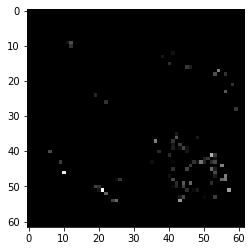

In [28]:
# 生成される画像を表示
noise = get_noise(128, z_dim, device=device)
print(generatorA(noise).size())
show_tensor_images(generatorA(noise))

=============モデル保存========================

In [24]:
dataset = "OCTMNIST"
midpath = os.path.join('/workspace/network_Gan/', dataset)
savepath = os.path.join(midpath, 'net_param.py')

In [4]:
torch.save(generatorA.state_dict(),savepath)

NameError: name 'generatorA' is not defined

=======================コードの確認＝＝＝＝＝＝＝＝＝＝＝＝＝＝

In [264]:
dataset = "MedMNIST"

In [265]:
midpath = os.path.join('/workspace/network_Gan/', dataset)
savepath = os.path.join(midpath, 'net_param.py')

In [266]:
generatorA = GeneratorA(nz = z_dim, img_size = 28).to(device) 
generatorA.load_state_dict(torch.load(savepath))

<All keys matched successfully>

In [267]:
def show_tensor_images(image_flattened, num_images=2, size=(1, 28, 28)):
  image = image_flattened.detach().cpu().view(-1, *size) # 画像のサイズ1x28x28に戻す
  image_grid = make_grid(image[:num_images], nrow=2) # 画像を並べる
  plt.imshow(image_grid.permute(1, 2, 0).squeeze()) # 画像の表示
  plt.axis("off")
  plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([128, 1, 28, 28])


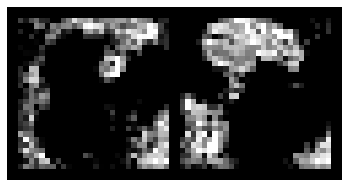

In [268]:
# 生成される画像を表示
noise = get_noise(128, z_dim, device=device)
print(generatorA(noise).size())
show_tensor_images(generatorA(noise))